<a href="https://colab.research.google.com/github/efatmae/Andrej-Karpathy-advice-to-train-NN-in-practice/blob/main/Becoming_one_with_the_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is an implementation attempt to reflect the first advice among 5 advices that Andrej Karpathy explanined in his post "A recipe for training neural networks." http://karpathy.github.io/2019/04/25/recipe/

##This is the first of a series of notebooks to follow these advices in practice. 

##sources: 

1.   https://gist.github.com/pgsrv/fdeea37fe316efa331334839d1028907
2.   https://github.com/howardyclo/papernotes/issues/56



## 1- Becoming one with the data
#### In this notebook we try to answer teh following questions about the data
##### 1- Are very local features enough or do we need global context?
##### 2- How much variation is there and what form does it take?
##### 3- What variation is spurious and could be preprocessed out?
##### 4- Does spatial position matter or do we want to average pool it out?
##### 5- How much does detail matter and how far could we afford to downsample the images?
##### 6- How noisy are the labels?


### IMDB

In [ ]:
from keras.datasets import imdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow import keras
import nltk
#nltk.download('punkt')
import sys
import codecs
import nltk
from nltk.corpus import stopwords

In [ ]:
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)

/home/fatma/.local/lib/python3.6/site-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/fatma/.local/lib/python3.6/site-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
def get_text(x):
  return " ".join( [reverse_index.get(i - 3, "#") for i in x])

In [ ]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [ ]:
def clean_text(text):
    default_stopwords = nltk.corpus.stopwords.words('english')
    cutome_stopwords = ["br","n't","'s","'m"]
    all_stopwords = default_stopwords + cutome_stopwords
    
    words = nltk.word_tokenize(text)

    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 2]
    
    #Remove non alphbetic characters
    words = [word for word in words if word.isalpha()]

    # Remove numbers
    words = [word for word in words if not word.isnumeric()]

    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]

    # Stemming words seems to make matters worse, disabled
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]

    # Remove stopwords
    words = [word for word in words if word not in all_stopwords]
    
    return words

In [ ]:
data_df = pd.DataFrame({"data_embs": data, "label":targets})

In [ ]:
len(data_df)

50000

In [ ]:
print("Categories:", np.unique(targets))
print("Number of unique words:", len(np.unique(np.hstack(data))))

Categories: [0 1]
Number of unique words: 9998


## Basic Data statistics

In [ ]:
length = [len(i) for i in data]
print("Average Review length:", np.mean(length))
print("max Review length:", np.max(length))
print("min Review length:", np.min(length))
print("Standard Deviation:", round(np.std(length)))

Average Review length: 234.75892
max Review length: 2494
min Review length: 7
Standard Deviation: 173


In [ ]:
length = [len(i) for i in data_sample["data_embs"]]
print("Average Review length:", np.mean(length))
print("max Review length:", np.max(length))
print("min Review length:", np.min(length))
print("Standard Deviation:", round(np.std(length)))

Average Review length: 232.9999
max Review length: 2315
min Review length: 7
Standard Deviation: 173


In [ ]:
index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 
data_df["data_text"] =  data_df["data_embs"].apply(lambda x:get_text(x))

1646592/1641221 [==============================] - 1s 1us/step


In [ ]:
data_df.to_csv("Data/IMDB.csv")

## Is there duplication?

In [ ]:
data_df.duplicated(subset=['data_text']).unique()

array([False,  True])

In [ ]:
data_df = data_df.drop_duplicates(subset=['data_text'])

In [ ]:
len(data_df)

49580

## The ratio of pos and neg samples

In [ ]:
pos_data = data_df[data_df["label"] == 1]
neg_data = data_df[data_df["label"] == 0]

In [ ]:
print("positive ratio",len(pos_data)/len(data_df))

positive ratio 0.5018354175070593


In [ ]:
print("negative ratio",len(neg_data)/len(data_df))

negative ratio 0.4981645824929407


## unique tokens and lexical diversity

In [ ]:
data_df["unique_tokens"] =  [sorted(set(str(i).split(" "))) for i in data_df["data_text"].values]

In [ ]:
data_df["lexical_diversity"] =  [lexical_diversity(str(i)) for i in data_df["data_text"].values]

(array([4.595e+04, 3.394e+03, 1.990e+02, 2.100e+01, 8.000e+00, 5.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.0027708 , 0.06916039, 0.13554998, 0.20193956, 0.26832915,
        0.33471873, 0.40110832, 0.46749791, 0.53388749, 0.60027708,
        0.66666667]),
 <BarContainer object of 10 artists>)

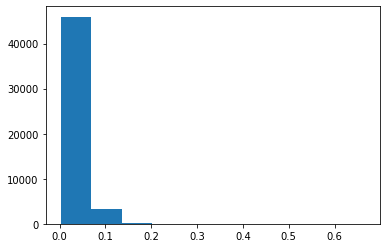

In [ ]:
plt.hist(data_df["lexical_diversity"])

In [ ]:
all_text = [str(i) for i in data_df["data_text"].values]
all_text = ".".join(all_text)
print("lexical diversity among all posts", lexical_diversity(all_text))

lexical diversity among all posts 7.875054521912801e-07


## Freq distribution

In [ ]:
def word_freq(text, num_freq):
    default_stopwords = nltk.corpus.stopwords.words('english')
    cutome_stopwords = ["br","n't","'s","'m"]
    all_stopwords = default_stopwords + cutome_stopwords
    
    words = nltk.word_tokenize(text)

    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 2]
    
    #Remove non alphbetic characters
    words = [word for word in words if word.isalpha()]

    # Remove numbers
    words = [word for word in words if not word.isnumeric()]

    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]

    # Stemming words seems to make matters worse, disabled
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]

    # Remove stopwords
    words = [word for word in words if word not in all_stopwords]

    # Calculate frequency distribution
    fdist = nltk.FreqDist(words)

    # Output top 50 words
    words = []
    for word, frequency in fdist.most_common(num_freq):
        words.append(word)
    return words    

In [ ]:
def word_ngram_freq(text, num_freq, ngram=2):
    default_stopwords = nltk.corpus.stopwords.words('english')
    cutome_stopwords = ["br","n't","'s","'m"]
    all_stopwords = default_stopwords + cutome_stopwords
    
    words = nltk.word_tokenize(text)
    
    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 2]
    
    #Remove non alphbetic characters
    words = [word for word in words if word.isalpha()]

    # Remove numbers
    words = [word for word in words if not word.isnumeric()]

    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]

    # Stemming words seems to make matters worse, disabled
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]

    # Remove stopwords
    words = [word for word in words if word not in all_stopwords]

    # Calculate frequency distribution
    fdist = nltk.FreqDist(ngrams(words, ngram))

    # Output top 50 words
    words = []
    for word, frequency in fdist.most_common(num_freq):
        words.append(word)
    return words    

In [ ]:
word_freq(all_text,50)

['movi',
 'film',
 'one',
 'like',
 'time',
 'make',
 'good',
 'charact',
 'see',
 'get',
 'veri',
 'watch',
 'would',
 'even',
 'stori',
 'onli',
 'realli',
 'well',
 'scene',
 'doe',
 'look',
 'show',
 'bad',
 'much',
 'end',
 'great',
 'could',
 'peopl',
 'love',
 'also',
 'becaus',
 'first',
 'think',
 'act',
 'play',
 'way',
 'thing',
 'made',
 'know',
 'ani',
 'say',
 'seem',
 'work',
 'plot',
 'actor',
 'two',
 'mani',
 'seen',
 'come',
 'want']

## Pos data analysis

In [ ]:
all_pos_text = [str(i) for i in pos_data["data_text"].values]
all_pos_text = ".".join(all_pos_text)
print("lexical diversity among all pos posts", lexical_diversity(all_pos_text))

lexical diversity among all pos posts 1.5563537770777644e-06


In [ ]:
word_freq(all_pos_text,50)

['film',
 'movi',
 'one',
 'like',
 'time',
 'veri',
 'good',
 'see',
 'stori',
 'charact',
 'make',
 'great',
 'well',
 'watch',
 'get',
 'love',
 'would',
 'show',
 'also',
 'realli',
 'play',
 'scene',
 'even',
 'onli',
 'doe',
 'first',
 'much',
 'end',
 'way',
 'peopl',
 'think',
 'best',
 'look',
 'life',
 'becaus',
 'year',
 'mani',
 'work',
 'made',
 'know',
 'could',
 'two',
 'perform',
 'thing',
 'act',
 'take',
 'man',
 'seen',
 'come',
 'say']

## Neg data analysis

In [ ]:
all_neg_text = [str(i) for i in neg_data["data_text"].values]
all_neg_text = ".".join(all_neg_text)
print("lexical diversity among all neg posts", lexical_diversity(all_neg_text))

lexical diversity among all neg posts 1.5941208269425548e-06


In [ ]:
word_freq(all_neg_text,50)

['movi',
 'film',
 'one',
 'like',
 'make',
 'bad',
 'even',
 'would',
 'get',
 'time',
 'watch',
 'good',
 'charact',
 'onli',
 'see',
 'realli',
 'look',
 'veri',
 'could',
 'scene',
 'stori',
 'doe',
 'act',
 'much',
 'becaus',
 'end',
 'peopl',
 'thing',
 'ani',
 'think',
 'made',
 'show',
 'plot',
 'well',
 'first',
 'seem',
 'say',
 'way',
 'know',
 'tri',
 'play',
 'actor',
 'want',
 'also',
 'whi',
 'never',
 'better',
 'seen',
 'ever',
 'come']

## No words the are in common between pos and neg subsets

In [ ]:
occ = 0
for i in word_freq(all_pos_text,50):
    if i in word_freq(all_neg_text,50):
        occ +=1

In [ ]:
set(word_freq(all_pos_text,50)) & set(word_freq(all_neg_text,50))

{'act',
 'also',
 'becaus',
 'charact',
 'come',
 'could',
 'doe',
 'end',
 'even',
 'film',
 'first',
 'get',
 'good',
 'know',
 'like',
 'look',
 'made',
 'make',
 'movi',
 'much',
 'one',
 'onli',
 'peopl',
 'play',
 'realli',
 'say',
 'scene',
 'see',
 'seen',
 'show',
 'stori',
 'thing',
 'think',
 'time',
 'veri',
 'watch',
 'way',
 'well',
 'would'}

## Ngram freq dist

In [ ]:
word_ngram_freq(all_text,num_freq=50,ngram=2)

[('look', 'like'),
 ('watch', 'movi'),
 ('ever', 'seen'),
 ('year', 'old'),
 ('veri', 'good'),
 ('special', 'effect'),
 ('even', 'though'),
 ('movi', 'like'),
 ('movi', 'ever'),
 ('one', 'best'),
 ('see', 'movi'),
 ('main', 'charact'),
 ('low', 'budget'),
 ('make', 'movi'),
 ('watch', 'film'),
 ('good', 'movi'),
 ('veri', 'well'),
 ('horror', 'movi'),
 ('wast', 'time'),
 ('want', 'see'),
 ('seem', 'like'),
 ('like', 'movi'),
 ('film', 'like'),
 ('horror', 'film'),
 ('bad', 'movi'),
 ('much', 'better'),
 ('first', 'time'),
 ('film', 'make'),
 ('movi', 'one'),
 ('make', 'film'),
 ('see', 'film'),
 ('year', 'ago'),
 ('new', 'york'),
 ('bad', 'guy'),
 ('onli', 'one'),
 ('real', 'life'),
 ('feel', 'like'),
 ('film', 'ever'),
 ('take', 'place'),
 ('high', 'school'),
 ('worst', 'movi'),
 ('film', 'one'),
 ('movi', 'made'),
 ('movi', 'would'),
 ('pretti', 'much'),
 ('movi', 'realli'),
 ('pretti', 'good'),
 ('one', 'thing'),
 ('onli', 'thing'),
 ('great', 'movi')]

In [ ]:
word_ngram_freq(all_text,num_freq=50,ngram=3)

[('movi', 'ever', 'seen'),
 ('worst', 'movi', 'ever'),
 ('film', 'ever', 'seen'),
 ('movi', 'ever', 'made'),
 ('worst', 'film', 'ever'),
 ('one', 'worst', 'movi'),
 ('film', 'ever', 'made'),
 ('new', 'york', 'citi'),
 ('veri', 'well', 'done'),
 ('onli', 'good', 'thing'),
 ('low', 'budget', 'movi'),
 ('one', 'best', 'movi'),
 ('one', 'best', 'film'),
 ('low', 'budget', 'film'),
 ('wast', 'time', 'money'),
 ('one', 'worst', 'film'),
 ('base', 'true', 'stori'),
 ('make', 'look', 'like'),
 ('make', 'ani', 'sens'),
 ('doe', 'good', 'job'),
 ('best', 'movi', 'ever'),
 ('would', 'like', 'see'),
 ('first', 'time', 'saw'),
 ('bad', 'act', 'bad'),
 ('doe', 'great', 'job'),
 ('veri', 'good', 'movi'),
 ('want', 'see', 'movi'),
 ('low', 'budget', 'horror'),
 ('seen', 'long', 'time'),
 ('movi', 'look', 'like'),
 ('look', 'forward', 'see'),
 ('two', 'main', 'charact'),
 ('wast', 'time', 'watch'),
 ('would', 'love', 'see'),
 ('good', 'thing', 'movi'),
 ('year', 'old', 'boy'),
 ('complet', 'wast', 'tim

In [ ]:
word_ngram_freq(all_text,num_freq=50,ngram=4)

[('worst', 'movi', 'ever', 'seen'),
 ('one', 'worst', 'movi', 'ever'),
 ('worst', 'film', 'ever', 'seen'),
 ('one', 'worst', 'film', 'ever'),
 ('worst', 'movi', 'ever', 'made'),
 ('worst', 'film', 'ever', 'made'),
 ('one', 'best', 'movi', 'ever'),
 ('onli', 'good', 'thing', 'movi'),
 ('best', 'movi', 'ever', 'seen'),
 ('doe', 'make', 'ani', 'sens'),
 ('movi', 'ever', 'seen', 'life'),
 ('movi', 'seen', 'long', 'time'),
 ('jean', 'claud', 'van', 'damm'),
 ('low', 'budget', 'horror', 'movi'),
 ('best', 'movi', 'ever', 'made'),
 ('good', 'guy', 'bad', 'guy'),
 ('one', 'best', 'film', 'ever'),
 ('one', 'best', 'movi', 'seen'),
 ('life', 'never', 'get', 'back'),
 ('low', 'budget', 'horror', 'film'),
 ('would', 'recommend', 'movi', 'anyon'),
 ('would', 'recommend', 'film', 'anyon'),
 ('one', 'worst', 'movi', 'seen'),
 ('doe', 'even', 'come', 'close'),
 ('doe', 'veri', 'good', 'job'),
 ('could', 'done', 'better', 'job'),
 ('vote', 'eight', 'titl', 'brazil'),
 ('funniest', 'movi', 'ever', 'seen

In [ ]:
word_ngram_freq(all_text,num_freq=50,ngram=5)

[('one', 'worst', 'movi', 'ever', 'seen'),
 ('one', 'worst', 'film', 'ever', 'seen'),
 ('one', 'worst', 'movi', 'ever', 'made'),
 ('worst', 'movi', 'ever', 'seen', 'life'),
 ('one', 'best', 'movi', 'ever', 'seen'),
 ('one', 'worst', 'film', 'ever', 'made'),
 ('greatest', 'show', 'ever', 'mad', 'full'),
 ('show', 'ever', 'mad', 'full', 'stop'),
 ('ever', 'mad', 'full', 'stop', 'greatest'),
 ('mad', 'full', 'stop', 'greatest', 'show'),
 ('full', 'stop', 'greatest', 'show', 'ever'),
 ('stop', 'greatest', 'show', 'ever', 'mad'),
 ('one', 'best', 'movi', 'ever', 'made'),
 ('worst', 'movi', 'ever', 'seen', 'seen'),
 ('star', 'rate', 'saturday', 'night', 'friday'),
 ('rate', 'saturday', 'night', 'friday', 'night'),
 ('saturday', 'night', 'friday', 'night', 'friday'),
 ('night', 'friday', 'night', 'friday', 'morn'),
 ('friday', 'night', 'friday', 'morn', 'sunday'),
 ('night', 'friday', 'morn', 'sunday', 'night'),
 ('friday', 'morn', 'sunday', 'night', 'monday'),
 ('morn', 'sunday', 'night', 'm

### pos subset

In [ ]:
word_ngram_freq(all_pos_text,num_freq=50,ngram=3)

[('movi', 'ever', 'seen'),
 ('new', 'york', 'citi'),
 ('one', 'best', 'movi'),
 ('veri', 'well', 'done'),
 ('one', 'best', 'film'),
 ('film', 'ever', 'made'),
 ('base', 'true', 'stori'),
 ('doe', 'great', 'job'),
 ('best', 'movi', 'ever'),
 ('movi', 'ever', 'made'),
 ('film', 'ever', 'seen'),
 ('first', 'time', 'saw'),
 ('doe', 'good', 'job'),
 ('well', 'worth', 'watch'),
 ('first', 'saw', 'movi'),
 ('would', 'love', 'see'),
 ('veri', 'good', 'movi'),
 ('would', 'like', 'see'),
 ('also', 'veri', 'good'),
 ('intern', 'film', 'festiv'),
 ('veri', 'good', 'film'),
 ('one', 'favorit', 'movi'),
 ('seen', 'long', 'time'),
 ('feel', 'good', 'movi'),
 ('work', 'veri', 'well'),
 ('first', 'saw', 'film'),
 ('high', 'recommend', 'movi'),
 ('one', 'time', 'favorit'),
 ('mani', 'year', 'ago'),
 ('film', 'one', 'best'),
 ('stori', 'take', 'place'),
 ('second', 'world', 'war'),
 ('realli', 'like', 'movi'),
 ('low', 'budget', 'film'),
 ('movi', 'one', 'best'),
 ('best', 'film', 'ever'),
 ('recommend',

In [ ]:
word_ngram_freq(all_pos_text,num_freq=50,ngram=4)

[('one', 'best', 'movi', 'ever'),
 ('best', 'movi', 'ever', 'seen'),
 ('one', 'best', 'movi', 'seen'),
 ('one', 'best', 'film', 'ever'),
 ('vote', 'eight', 'titl', 'brazil'),
 ('one', 'best', 'film', 'seen'),
 ('best', 'movi', 'ever', 'made'),
 ('vote', 'seven', 'titl', 'brazil'),
 ('funniest', 'movi', 'ever', 'seen'),
 ('good', 'guy', 'bad', 'guy'),
 ('movi', 'seen', 'long', 'time'),
 ('doe', 'veri', 'good', 'job'),
 ('well', 'written', 'well', 'act'),
 ('greatest', 'show', 'ever', 'mad'),
 ('toronto', 'intern', 'film', 'festiv'),
 ('show', 'ever', 'mad', 'full'),
 ('ever', 'mad', 'full', 'stop'),
 ('mad', 'full', 'stop', 'greatest'),
 ('full', 'stop', 'greatest', 'show'),
 ('stop', 'greatest', 'show', 'ever'),
 ('movi', 'base', 'true', 'stori'),
 ('best', 'film', 'ever', 'made'),
 ('saw', 'movi', 'first', 'time'),
 ('greatest', 'film', 'ever', 'made'),
 ('never', 'seen', 'anyth', 'like'),
 ('would', 'recommend', 'movi', 'anyon'),
 ('one', 'favorit', 'movi', 'time'),
 ('lose', 'friend

In [ ]:
word_ngram_freq(all_pos_text,num_freq=50,ngram=5)

[('one', 'best', 'movi', 'ever', 'seen'),
 ('greatest', 'show', 'ever', 'mad', 'full'),
 ('show', 'ever', 'mad', 'full', 'stop'),
 ('ever', 'mad', 'full', 'stop', 'greatest'),
 ('mad', 'full', 'stop', 'greatest', 'show'),
 ('full', 'stop', 'greatest', 'show', 'ever'),
 ('stop', 'greatest', 'show', 'ever', 'mad'),
 ('one', 'best', 'movi', 'ever', 'made'),
 ('jacqu', 'univers', 'pari', 'univers', 'pari'),
 ('one', 'funniest', 'movi', 'ever', 'seen'),
 ('one', 'best', 'film', 'ever', 'made'),
 ('one', 'best', 'film', 'ever', 'seen'),
 ('went', 'bought', 'case', 'went', 'bought'),
 ('bought', 'case', 'went', 'bought', 'case'),
 ('mad', 'mad', 'mad', 'mad', 'world'),
 ('case', 'went', 'bought', 'case', 'went'),
 ('univers', 'pari', 'univers', 'saint', 'quentin'),
 ('palm', 'spring', 'intern', 'film', 'festiv'),
 ('one', 'greatest', 'film', 'ever', 'made'),
 ('best', 'movi', 'seen', 'long', 'time'),
 ('good', 'perform', 'product', 'design', 'spectacular'),
 ('perform', 'product', 'design', '

### neg subset

In [ ]:
word_ngram_freq(all_neg_text,num_freq=50,ngram=3)

[('worst', 'movi', 'ever'),
 ('movi', 'ever', 'seen'),
 ('worst', 'film', 'ever'),
 ('one', 'worst', 'movi'),
 ('film', 'ever', 'seen'),
 ('movi', 'ever', 'made'),
 ('onli', 'good', 'thing'),
 ('wast', 'time', 'money'),
 ('one', 'worst', 'film'),
 ('film', 'ever', 'made'),
 ('make', 'ani', 'sens'),
 ('low', 'budget', 'movi'),
 ('bad', 'act', 'bad'),
 ('make', 'look', 'like'),
 ('low', 'budget', 'film'),
 ('wast', 'time', 'watch'),
 ('movi', 'look', 'like'),
 ('complet', 'wast', 'time'),
 ('worst', 'movi', 'seen'),
 ('good', 'thing', 'movi'),
 ('could', 'care', 'less'),
 ('low', 'budget', 'horror'),
 ('realli', 'bad', 'movi'),
 ('mysteri', 'scienc', 'theater'),
 ('want', 'see', 'movi'),
 ('worst', 'ever', 'seen'),
 ('new', 'york', 'citi'),
 ('first', 'half', 'hour'),
 ('blah', 'blah', 'blah'),
 ('doe', 'make', 'sens'),
 ('could', 'much', 'better'),
 ('make', 'good', 'movi'),
 ('look', 'forward', 'see'),
 ('much', 'better', 'movi'),
 ('realli', 'realli', 'bad'),
 ('film', 'look', 'like')

In [ ]:
word_ngram_freq(all_neg_text,num_freq=50,ngram=4)

[('worst', 'movi', 'ever', 'seen'),
 ('one', 'worst', 'movi', 'ever'),
 ('worst', 'film', 'ever', 'seen'),
 ('one', 'worst', 'film', 'ever'),
 ('worst', 'movi', 'ever', 'made'),
 ('worst', 'film', 'ever', 'made'),
 ('onli', 'good', 'thing', 'movi'),
 ('doe', 'make', 'ani', 'sens'),
 ('movi', 'ever', 'seen', 'life'),
 ('jean', 'claud', 'van', 'damm'),
 ('life', 'never', 'get', 'back'),
 ('one', 'worst', 'movi', 'seen'),
 ('low', 'budget', 'horror', 'movi'),
 ('doe', 'even', 'come', 'close'),
 ('possibl', 'worst', 'movi', 'ever'),
 ('realli', 'want', 'like', 'movi'),
 ('movi', 'seen', 'long', 'time'),
 ('onli', 'good', 'thing', 'say'),
 ('could', 'done', 'better', 'job'),
 ('movi', 'ever', 'seen', 'seen'),
 ('wast', 'time', 'watch', 'movi'),
 ('vote', 'four', 'titl', 'brazil'),
 ('far', 'worst', 'movi', 'ever'),
 ('movi', 'complet', 'wast', 'time'),
 ('realli', 'want', 'like', 'film'),
 ('low', 'budget', 'horror', 'film'),
 ('possibl', 'worst', 'film', 'ever'),
 ('absolut', 'worst', 'mov

In [ ]:
word_ngram_freq(all_neg_text,num_freq=50,ngram=5)

[('one', 'worst', 'movi', 'ever', 'seen'),
 ('one', 'worst', 'film', 'ever', 'seen'),
 ('one', 'worst', 'movi', 'ever', 'made'),
 ('worst', 'movi', 'ever', 'seen', 'life'),
 ('one', 'worst', 'film', 'ever', 'made'),
 ('worst', 'movi', 'ever', 'seen', 'seen'),
 ('possibl', 'worst', 'movi', 'ever', 'seen'),
 ('movi', 'ever', 'seen', 'entir', 'life'),
 ('without', 'doubt', 'worst', 'movi', 'ever'),
 ('movi', 'one', 'worst', 'movi', 'ever'),
 ('worst', 'horror', 'movi', 'ever', 'seen'),
 ('star', 'rate', 'saturday', 'night', 'friday'),
 ('rate', 'saturday', 'night', 'friday', 'night'),
 ('saturday', 'night', 'friday', 'night', 'friday'),
 ('night', 'friday', 'night', 'friday', 'morn'),
 ('friday', 'night', 'friday', 'morn', 'sunday'),
 ('night', 'friday', 'morn', 'sunday', 'night'),
 ('friday', 'morn', 'sunday', 'night', 'monday'),
 ('morn', 'sunday', 'night', 'monday', 'morn'),
 ('far', 'worst', 'movi', 'ever', 'seen'),
 ('hour', 'life', 'never', 'get', 'back'),
 ('quit', 'possibl', 'wors

In [ ]:
set(["A","B","C"]) & set(["A","1","2"])

{'A'}

In [ ]:
set(word_ngram_freq(all_pos_text,num_freq=50,ngram=5)) & set(word_ngram_freq(all_neg_text,num_freq=50,ngram=5))

{('one', 'best', 'movi', 'ever', 'made')}

In [ ]:
set(word_ngram_freq(all_pos_text,num_freq=50,ngram=4)) & set(word_ngram_freq(all_neg_text,num_freq=50,ngram=4))

{('low', 'budget', 'horror', 'film'),
 ('movi', 'seen', 'long', 'time'),
 ('would', 'recommend', 'film', 'anyon')}

In [ ]:
set(word_ngram_freq(all_pos_text,num_freq=50,ngram=3)) & set(word_ngram_freq(all_neg_text,num_freq=50,ngram=3))

{('film', 'ever', 'made'),
 ('film', 'ever', 'seen'),
 ('look', 'forward', 'see'),
 ('low', 'budget', 'film'),
 ('movi', 'ever', 'made'),
 ('movi', 'ever', 'seen'),
 ('new', 'york', 'citi'),
 ('seen', 'long', 'time'),
 ('two', 'main', 'charact')}

## Context based on all text

In [ ]:
all_text_words = clean_text(all_text)

In [ ]:
all_data_nltk_txt = nltk.Text(word.lower() for word in all_text_words)

In [ ]:
all_data_nltk_txt.similar('good')

movi film one bad like great make well watch see much onli think time
funni interest get love end realli


In [ ]:
all_data_nltk_txt.similar('movi')

film one like stori time realli would watch show charact see good even
make onli becaus think thing end act


In [ ]:
all_data_nltk_txt.similar('film')

movi one like time stori realli would show charact watch good see even
onli make think becaus thing scene doe


In [ ]:
all_data_nltk_txt.similar('like')

movi film one good watch make see realli think would bad onli get even
great love time becaus made end


## Context based on pos subset

In [ ]:
pos_text_words = clean_text(all_pos_text)
pos_data_nltk_txt = nltk.Text(word.lower() for word in pos_text_words)

In [ ]:
pos_data_nltk_txt.similar('movi')

film one like stori show time realli watch see would charact great
think good veri also make well love thing


In [ ]:
pos_data_nltk_txt.similar('film')

movi one like stori time show realli watch charact would see great
veri good also make well think scene thing


In [ ]:
pos_data_nltk_txt.similar('good')

great film movi like one well make love watch see much best enjoy
funni time think bad interest first end


In [ ]:
pos_data_nltk_txt.similar('bad')

good movi one film like great see watch make well think love onli time
first best enjoy much becaus get


In [ ]:
pos_data_nltk_txt.similar('like')

film movi one good watch make see great love realli think time show
enjoy onli also made get would well


## Context on neg subset

In [ ]:
neg_text_words = clean_text(all_neg_text)
neg_data_nltk_txt = nltk.Text(word.lower() for word in neg_text_words)

In [ ]:
neg_data_nltk_txt.similar('movi')

film one like realli bad would even thing stori watch act time onli
good make becaus could charact think see


In [ ]:
neg_data_nltk_txt.similar('film')

movi one like realli even bad would time stori thing onli watch act
charact make good becaus could doe think


In [ ]:
neg_data_nltk_txt.similar('good')

bad movi film one like make watch onli great see much better think
interest realli even get funni well first


In [ ]:
neg_data_nltk_txt.similar('bad')

movi good film one like make watch realli onli see even becaus think
well made poor act end would much


In [ ]:
neg_data_nltk_txt.similar('like')

movi film one bad good make watch realli onli would even think see get
made could becaus say know end


## POS tagging and NER

### all text

In [ ]:
all_text_pos = nltk.pos_tag(nltk.word_tokenize(all_text))

In [ ]:
tag_fd = nltk.FreqDist(tag for (word, tag) in all_text_pos)
tag_fd.most_common()

[('NN', 2076052),
 ('DT', 1353694),
 ('IN', 1347061),
 ('JJ', 1038318),
 ('RB', 787690),
 ('#', 683521),
 ('VBZ', 501147),
 ('PRP', 487090),
 ('NNS', 453450),
 ('CC', 445467),
 ('VB', 438024),
 ('VBD', 321923),
 ('VBP', 307281),
 ('TO', 266539),
 ('VBN', 220223),
 ('VBG', 211379),
 ('PRP$', 168290),
 ('CD', 140401),
 ('MD', 135455),
 ('WP', 74821),
 ('WRB', 68786),
 ('WDT', 65436),
 ('RP', 56160),
 ('JJS', 38342),
 ('JJR', 36116),
 ('EX', 31600),
 ('POS', 23597),
 ('RBR', 21112),
 ('PDT', 15506),
 ('RBS', 10000),
 ('.', 3818),
 ('FW', 3698),
 ('NNP', 2224),
 ('WP$', 1887),
 ("''", 1189),
 ('UH', 747),
 ('$', 234),
 ('NNPS', 62),
 ('SYM', 38)]

### clean text

In [ ]:
all_text_pos_clean = nltk.pos_tag(nltk.word_tokenize(" ".join(clean_text(all_text))))
tag_fd = nltk.FreqDist(tag for (word, tag) in all_text_pos_clean)
tag_fd.most_common()

[('NN', 2625749),
 ('JJ', 1075204),
 ('VBP', 296145),
 ('RB', 261686),
 ('VB', 186140),
 ('IN', 145995),
 ('VBD', 128204),
 ('NNS', 105157),
 ('CD', 81930),
 ('VBN', 72050),
 ('MD', 65233),
 ('VBZ', 33824),
 ('JJS', 30782),
 ('JJR', 19912),
 ('DT', 16227),
 ('FW', 14651),
 ('RBR', 12500),
 ('CC', 7146),
 ('VBG', 6451),
 ('RP', 4855),
 ('NNP', 4443),
 ('RBS', 1893),
 ('WP$', 1887),
 ('PRP', 1578),
 ('WP', 1221),
 ('UH', 765),
 ('WRB', 708),
 ('WDT', 484),
 ('PRP$', 255),
 ('PDT', 66),
 ('EX', 60),
 ('POS', 13),
 ('$', 11),
 ('TO', 7),
 ("''", 6),
 ('``', 4),
 ('NNPS', 3)]

#### all adj in the all text

In [ ]:
len(all_text_pos)

11838378

In [ ]:
[i[0] for i in all_text_pos if i[1] == 'JJ']

['brilliant',
 'robert',
 'amazing',
 'same',
 'same',
 'scottish',
 'i',
 'real',
 'great',
 'much',
 'i',
 'sad',
 'good',
 'little',
 'brilliant',
 'big',
 'whole',
 'whole',
 'true',
 'big',
 'big',
 'bad',
 'giant',
 'terrible',
 'thin',
 'ridiculous',
 'laughable',
 'damn',
 'funny',
 'equal',
 'big',
 'boobs',
 'cut',
 'trashy',
 'bad',
 'only',
 'good',
 'old',
 'bad',
 'then.',
 'first',
 'bad',
 'other',
 'feeble',
 'great',
 'life.',
 'traditional',
 'many',
 'elderly',
 'alive',
 'br',
 'many',
 'same',
 'local',
 'become',
 'invisible',
 'emotional',
 'rugged',
 'special',
 'rough',
 'br',
 'br',
 'frustration',
 'first',
 'western',
 'deeper',
 'last',
 'bloody',
 'old',
 'accepted',
 'own',
 'honest',
 'beautiful',
 'i',
 'i',
 'famous',
 'true',
 'unique',
 'old',
 'cheap',
 'wrong',
 'wrong',
 'mid',
 'asleep',
 'good',
 'i',
 'else',
 'american',
 'psycho',
 'whole',
 'life.',
 'funny',
 'russian',
 'other',
 'documentary',
 'br',
 'contrary',
 'whole',
 'br',
 'lavis

In [ ]:
all_jj = []
for i,j in all_text_pos:
    if j == 'JJ':
        all_jj.append(i)

len(all_jj)    

1038318

In [ ]:
all_jj

['brilliant',
 'robert',
 'amazing',
 'same',
 'same',
 'scottish',
 'i',
 'real',
 'great',
 'much',
 'i',
 'sad',
 'good',
 'little',
 'brilliant',
 'big',
 'whole',
 'whole',
 'true',
 'big',
 'big',
 'bad',
 'giant',
 'terrible',
 'thin',
 'ridiculous',
 'laughable',
 'damn',
 'funny',
 'equal',
 'big',
 'boobs',
 'cut',
 'trashy',
 'bad',
 'only',
 'good',
 'old',
 'bad',
 'then.',
 'first',
 'bad',
 'other',
 'feeble',
 'great',
 'life.',
 'traditional',
 'many',
 'elderly',
 'alive',
 'br',
 'many',
 'same',
 'local',
 'become',
 'invisible',
 'emotional',
 'rugged',
 'special',
 'rough',
 'br',
 'br',
 'frustration',
 'first',
 'western',
 'deeper',
 'last',
 'bloody',
 'old',
 'accepted',
 'own',
 'honest',
 'beautiful',
 'i',
 'i',
 'famous',
 'true',
 'unique',
 'old',
 'cheap',
 'wrong',
 'wrong',
 'mid',
 'asleep',
 'good',
 'i',
 'else',
 'american',
 'psycho',
 'whole',
 'life.',
 'funny',
 'russian',
 'other',
 'documentary',
 'br',
 'contrary',
 'whole',
 'br',
 'lavis

#### all adj in pos subset

In [ ]:
pos_text_pos = nltk.pos_tag(nltk.word_tokenize(" ".join(clean_text(all_pos_text))))

['brilliant',
 'direct',
 'robert',
 'amaz',
 'scottish',
 'real',
 'great',
 'brilliant',
 'much',
 'everyon',
 'fish',
 'cri',
 'cri',
 'brilliant',
 'list',
 'becaus',
 'big',
 'whole',
 'whole',
 'true',
 'ladi',
 'charact',
 'aliv',
 'live',
 'local',
 'give',
 'close',
 'stori',
 'becom',
 'invis',
 'inspir',
 'emot',
 'stori',
 'magic',
 'befor',
 'introduc',
 'generat',
 'stori',
 'stori',
 'give',
 'special',
 'hear',
 'short',
 'rais',
 'western',
 'speak',
 'deeper',
 'ancient',
 'fiction',
 'last',
 'stori',
 'stori',
 'old',
 'connect',
 'live',
 'slight',
 'stori',
 'pictur',
 'offic',
 'famous',
 'true',
 'uniqu',
 'old',
 'onli',
 'lavish',
 'solid',
 'classic',
 'northam',
 'good',
 'long',
 'explain',
 'harsh',
 'much',
 'good',
 'believ',
 'brilliant',
 'rare',
 'late',
 'someth',
 'special',
 'uniqu',
 'know',
 'surpris',
 'top',
 'great',
 'stori',
 'movi',
 'good',
 'everi',
 'second',
 'much',
 'everyth',
 'much',
 'touch',
 'great',
 'engag',
 'much',
 'human',


In [ ]:
pos_jj = []
for i,j in pos_text_pos:
    if j == 'JJ':
        pos_jj.append(i)

len(pos_jj)    

544823

In [ ]:
pos_jj

['brilliant',
 'direct',
 'robert',
 'amaz',
 'scottish',
 'real',
 'great',
 'brilliant',
 'much',
 'everyon',
 'fish',
 'cri',
 'cri',
 'brilliant',
 'list',
 'becaus',
 'big',
 'whole',
 'whole',
 'true',
 'ladi',
 'charact',
 'aliv',
 'live',
 'local',
 'give',
 'close',
 'stori',
 'becom',
 'invis',
 'inspir',
 'emot',
 'stori',
 'magic',
 'befor',
 'introduc',
 'generat',
 'stori',
 'stori',
 'give',
 'special',
 'hear',
 'short',
 'rais',
 'western',
 'speak',
 'deeper',
 'ancient',
 'fiction',
 'last',
 'stori',
 'stori',
 'old',
 'connect',
 'live',
 'slight',
 'stori',
 'pictur',
 'offic',
 'famous',
 'true',
 'uniqu',
 'old',
 'onli',
 'lavish',
 'solid',
 'classic',
 'northam',
 'good',
 'long',
 'explain',
 'harsh',
 'much',
 'good',
 'believ',
 'brilliant',
 'rare',
 'late',
 'someth',
 'special',
 'uniqu',
 'know',
 'surpris',
 'top',
 'great',
 'stori',
 'movi',
 'good',
 'everi',
 'second',
 'much',
 'everyth',
 'much',
 'touch',
 'great',
 'engag',
 'much',
 'human',


In [ ]:
len(pos_jj)

5699

#### all adj in neg subset

In [ ]:
neg_text_pos = nltk.pos_tag(nltk.word_tokenize(" ".join(clean_text(all_neg_text))))

['big',
 'big',
 'bad',
 'thin',
 'script',
 'sicken',
 'funni',
 'equal',
 'big',
 'sicken',
 'actual',
 'everi',
 'bodi',
 'close',
 'bad',
 'onli',
 'good',
 'old',
 'bad',
 'audienc',
 'aim',
 'touch',
 'bad',
 'everyon',
 'general',
 'actual',
 'great',
 'worst',
 'mistak',
 'cheap',
 'wrong',
 'wrong',
 'mid',
 'whi',
 'good',
 'bash',
 'damn',
 'movi',
 'american',
 'dark',
 'crap',
 'actual',
 'ruin',
 'whole',
 'russian',
 'whole',
 'stori',
 'hous',
 'unsur',
 'unhappi',
 'calm',
 'franci',
 'right',
 'truth',
 'produc',
 'direct',
 'april',
 'total',
 'utter',
 'charact',
 'realli',
 'poor',
 'unlik',
 'slow',
 'long',
 'twist',
 'loud',
 'big',
 'insid',
 'suppos',
 'young',
 'clear',
 'new',
 'hous',
 'david',
 'much',
 'befor',
 'everi',
 'potent',
 'terribl',
 'aspect',
 'bad',
 'good',
 'direct',
 'blood',
 'veri',
 'middl',
 'atmospher',
 'lesbian',
 'low',
 'much',
 'modern',
 'low',
 'bad',
 'forgett',
 'unknown',
 'write',
 'anyth',
 'ultra',
 'thin',
 'rubbish',
 '

In [ ]:
neg_jj = []
for i,j in neg_text_pos:
    if j == 'JJ':
        neg_jj.append(i)

len(neg_jj)    

530481

In [ ]:
neg_jj

['big',
 'big',
 'bad',
 'thin',
 'script',
 'sicken',
 'funni',
 'equal',
 'big',
 'sicken',
 'actual',
 'everi',
 'bodi',
 'close',
 'bad',
 'onli',
 'good',
 'old',
 'bad',
 'audienc',
 'aim',
 'touch',
 'bad',
 'everyon',
 'general',
 'actual',
 'great',
 'worst',
 'mistak',
 'cheap',
 'wrong',
 'wrong',
 'mid',
 'whi',
 'good',
 'bash',
 'damn',
 'movi',
 'american',
 'dark',
 'crap',
 'actual',
 'ruin',
 'whole',
 'russian',
 'whole',
 'stori',
 'hous',
 'unsur',
 'unhappi',
 'calm',
 'franci',
 'right',
 'truth',
 'produc',
 'direct',
 'april',
 'total',
 'utter',
 'charact',
 'realli',
 'poor',
 'unlik',
 'slow',
 'long',
 'twist',
 'loud',
 'big',
 'insid',
 'suppos',
 'young',
 'clear',
 'new',
 'hous',
 'david',
 'much',
 'befor',
 'everi',
 'potent',
 'terribl',
 'aspect',
 'bad',
 'good',
 'direct',
 'blood',
 'veri',
 'middl',
 'atmospher',
 'lesbian',
 'low',
 'much',
 'modern',
 'low',
 'bad',
 'forgett',
 'unknown',
 'write',
 'anyth',
 'ultra',
 'thin',
 'rubbish',
 '

In [ ]:
len(neg_jj)

530481

In [ ]:
len([i for i in pos_jj if i not in neg_jj]),len([i for i in neg_jj if i not in pos_jj])

(935, 593)

In [ ]:
set([i for i in pos_jj if i not in neg_jj])

{'adel',
 'ahmad',
 'allianc',
 'alot',
 'aniston',
 'antwon',
 'apartheid',
 'baker',
 'bakshi',
 'ballroom',
 'banter',
 'bargain',
 'bartend',
 'barton',
 'basil',
 'basing',
 'batwoman',
 'beatl',
 'beau',
 'beckham',
 'bedroom',
 'beetl',
 'belt',
 'benjamin',
 'benoit',
 'bitch',
 'bloodbath',
 'bon',
 'boom',
 'boost',
 'border',
 'boyer',
 'brashear',
 'brook',
 'brosnan',
 'bucket',
 'busbi',
 'caprica',
 'carel',
 'carfac',
 'carmen',
 'caron',
 'carpet',
 'caruso',
 'celin',
 'cena',
 'censor',
 'chamberlain',
 'cheadl',
 'cheung',
 'christensen',
 'clarenc',
 'clay',
 'cliffhang',
 'clutter',
 'coaster',
 'cocktail',
 'collett',
 'compassion',
 'conductor',
 'coop',
 'corbett',
 'corbin',
 'crawford',
 'creasi',
 'crenna',
 'cruella',
 'curtain',
 'darius',
 'darker',
 'deathtrap',
 'deliver',
 'der',
 'din',
 'dom',
 'dominick',
 'downey',
 'draft',
 'drummer',
 'dukaki',
 'durbin',
 'duryea',
 'dyke',
 'dynamit',
 'eal',
 'edmund',
 'einstein',
 'esther',
 'europa',
 'exc

In [ ]:
[i for i in neg_jj if i not in pos_jj]

['saif',
 'kareena',
 'cannib',
 'govinda',
 'kareena',
 'frost',
 'herring',
 'godzilla',
 'diver',
 'moron',
 'render',
 'sasquatch',
 'rack',
 'thinner',
 'bio',
 'contin',
 'abound',
 'scenario',
 'moron',
 'abomin',
 'btk',
 'camcord',
 'tashan',
 'tashan',
 'kareena',
 'kareena',
 'cannib',
 'genet',
 'halt',
 'sheet',
 'godzilla',
 'benson',
 'intermin',
 'rodney',
 'combat',
 'porno',
 'wrestler',
 'intermin',
 'chandler',
 'sasquatch',
 'rewrit',
 'yawn',
 'cannib',
 'thinner',
 'slater',
 'btk',
 'galactica',
 'cannib',
 'grendel',
 'hine',
 'miranda',
 'abomin',
 'masturb',
 'sarn',
 'sarn',
 'rosenstrass',
 'intermin',
 'onto',
 'intermin',
 'garcia',
 'hotel',
 'firework',
 'mama',
 'lds',
 'handicap',
 'darkman',
 'garcia',
 'toro',
 'marcus',
 'wrestler',
 'tomb',
 'claus',
 'hobgoblin',
 'garcia',
 'genet',
 'hobgoblin',
 'hobgoblin',
 'ripoff',
 'contin',
 'minus',
 'hiv',
 'porno',
 'hobgoblin',
 'intermin',
 'godzilla',
 'meyer',
 'kristofferson',
 'beowulf',
 'motel

## NER

In [ ]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk.chunk import conlltags2tree, tree2conlltags

In [ ]:
ner = nltk.ne_chunk(all_text_pos, binary=False)

In [ ]:
iob_tagged = tree2conlltags(ner)

In [ ]:
iob_tagged

[('film', 'NN', 'O'),
 ('brilliant', 'JJ', 'O'),
 ('cast', 'NN', 'O'),
 ('locat', 'NN', 'O'),
 ('sceneri', 'NN', 'O'),
 ('stori', 'NN', 'O'),
 ('direct', 'JJ', 'O'),
 ('everyon', 'NN', 'O'),
 ('realli', 'NN', 'O'),
 ('suit', 'NN', 'O'),
 ('part', 'NN', 'O'),
 ('play', 'NN', 'O'),
 ('could', 'MD', 'O'),
 ('imagin', 'VB', 'O'),
 ('robert', 'JJ', 'O'),
 ('amaz', 'JJ', 'O'),
 ('actor', 'NN', 'O'),
 ('director', 'NN', 'O'),
 ('father', 'NN', 'O'),
 ('came', 'VBD', 'O'),
 ('scottish', 'JJ', 'O'),
 ('island', 'NN', 'O'),
 ('love', 'VB', 'O'),
 ('fact', 'NN', 'O'),
 ('real', 'JJ', 'O'),
 ('connect', 'NN', 'O'),
 ('film', 'NN', 'O'),
 ('witti', 'NN', 'O'),
 ('remark', 'NN', 'O'),
 ('throughout', 'IN', 'O'),
 ('film', 'NN', 'O'),
 ('great', 'JJ', 'O'),
 ('brilliant', 'JJ', 'O'),
 ('much', 'JJ', 'O'),
 ('bought', 'NN', 'O'),
 ('film', 'NN', 'O'),
 ('soon', 'RB', 'O'),
 ('releas', 'NNS', 'O'),
 ('would', 'MD', 'O'),
 ('recommend', 'VB', 'O'),
 ('everyon', 'JJ', 'O'),
 ('watch', 'NN', 'O'),
 ('fli'

In [ ]:
np.unique([i[2] for i in iob_tagged])

array(['O'], dtype='<U1')

In [ ]:
tree2conlltags(nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize("France")),binary=False))

[('France', 'NNP', 'B-GPE')]

## visualize distribution

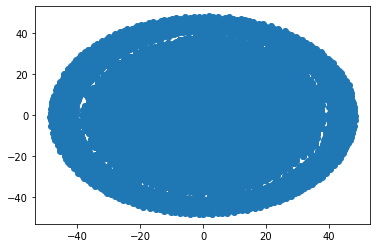

In [ ]:
pad_all_data_seq = keras.preprocessing.sequence.pad_sequences(data_df["data_embs"], maxlen=2315)
all_data_embs = tsne.fit_transform(pad_all_data_seq)
plt.scatter(all_data_embs[:,0],all_data_embs[:,1], label="all data")

## Take a data sample

In [ ]:
data_sample = data_df.sample(10000)

In [ ]:
pos_data_sample = data_sample[data_sample["label"] == 1]
neg_data_sampe = data_sample[data_sample["label"] == 0]

In [ ]:
len(pos_data),len(neg_data)

(25000, 25000)

In [ ]:
len(pos_data_sample),len(neg_data_sampe)

(5045, 4955)

In [ ]:
pad_data_seq_sample = keras.preprocessing.sequence.pad_sequences(data_sample["data_embs"], maxlen=2315)
pad_pos_data_seq_sample = keras.preprocessing.sequence.pad_sequences(pos_data_sample["data_embs"], maxlen=2315)
pad_neg_data_seq_sample = keras.preprocessing.sequence.pad_sequences(neg_data_sampe["data_embs"], maxlen=2315)

In [ ]:
data_sample_embs = tsne.fit_transform(pad_data_seq_sample)
pos_sample_data_embs = tsne.fit_transform(pad_pos_data_seq_sample)
neg_sample_data_embs = tsne.fit_transform(pad_neg_data_seq_sample)

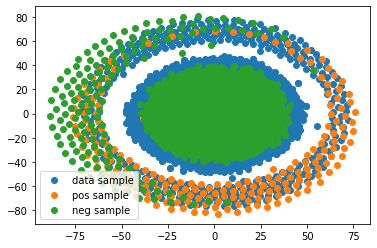

In [ ]:
plt.scatter(data_sample_embs[:,0],data_sample_embs[:,1], label="data sample")
plt.scatter(pos_sample_data_embs[:,0],pos_sample_data_embs[:,1], label="pos sample")
plt.scatter(neg_sample_data_embs[:,0],neg_sample_data_embs[:,1], label="neg sample")
plt.legend()

In [ ]:
data_sample["2d_emd_0"] = [i[0] for i in data_sample_embs]
data_sample["2d_emd_1"] = [i[1] for i in data_sample_embs]

In [ ]:
data_sample.set_index(np.arange(0,len(data_sample)))

,data_embs,label,data_text,2d_emd_0,2d_emd_1
0,"[1, 13, 296, 14, 20, 6, 378, 7, 2485, 596, 5, ...",0,# i watched this movie a couple of weeks ago a...,-0.374187,-20.840380
1,"[1, 44, 677, 234, 11, 5, 13, 219, 121, 14, 16,...",0,# about five minutes in and i saw where this w...,51.976234,40.835911
2,"[1, 261, 4, 2588, 26, 1931, 11, 2, 8, 85, 3798...",0,# although the figures are higher in # to othe...,12.199841,-20.611288
3,"[1, 14, 32, 610, 179, 2428, 35, 56, 5, 582, 79...",0,# this all looked quite promising an up and co...,-19.717045,8.293743
4,"[1, 13, 43, 657, 13, 16, 2, 195, 8, 135, 89, 5...",1,# i just wish i was # enough to say how good t...,-14.101071,-1.459108
...,...,...,...,...,...
9995,"[1, 13, 244, 6, 891, 291, 154, 9080, 39, 1831,...",1,# i am a 20 year old bloke from england i don'...,30.622494,3.358813
9996,"[1, 73, 13, 244, 170, 8, 140, 429, 4, 9556, 23...",1,# well i am going to go against the grain on t...,8.823808,-22.913092
9997,"[1, 4, 4101, 935, 18, 14, 20, 9, 4, 2221, 7, 1...",1,# the primary plus for this movie is the combi...,13.871989,-28.701876
9998,"[1, 121, 16, 14, 22, 54, 13, 16, 6, 554, 103, ...",1,# where was this film when i was a kid after h...,-0.008560,0.263328


In [ ]:
inner_ring_data = data_sample[(data_sample["2d_emd_0"] >-40) &
            (data_sample["2d_emd_0"] < 40)&
            (data_sample["2d_emd_1"] >-40) &
            (data_sample["2d_emd_1"] < 40)][["data_text","label"]]

In [ ]:
outer_ring_data = data_sample[~ data_sample.index.isin(inner_ring_data.index)]

In [ ]:
outer_length = [len(i) for i in outer_ring_data["data_text"]]
inner_length = [len(i) for i in inner_ring_data["data_text"]]

In [ ]:
print("Average Review length:", np.mean(outer_length))
print("max Review length:", np.max(outer_length))
print("min Review length:", np.min(outer_length))
print("Standard Deviation:", round(np.std(outer_length)))

Average Review length: 2130.9383561643835
max Review length: 7424
min Review length: 286
Standard Deviation: 1284


In [ ]:
print("Average Review length:", np.mean(inner_length))
print("max Review length:", np.max(inner_length))
print("min Review length:", np.min(inner_length))
print("Standard Deviation:", round(np.std(inner_length)))

Average Review length: 1091.8326860841423
max Review length: 11549
min Review length: 32
Standard Deviation: 780


In [ ]:
inner_ring_data["lexical_diversity"] =  [lexical_diversity(str(i)) for i in inner_ring_data["data_text"].values]
outer_ring_data["lexical_diversity"] =  [lexical_diversity(str(i)) for i in outer_ring_data["data_text"].values]

/home/fatma/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


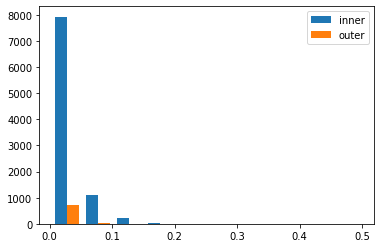

In [ ]:
plt.hist([inner_ring_data["lexical_diversity"], outer_ring_data["lexical_diversity"]],label=["inner","outer"])
plt.legend()

In [ ]:
all_inner_text = [str(i) for i in inner_ring_data["data_text"].values]
all_inner_text = ".".join(all_inner_text)
word_freq(all_inner_text,10)

br;35067
movie;15712
film;13770
's;13616
n't;11559
one;9105
like;6834
good;5370
would;4638
time;4345


In [ ]:
all_outer_text = [str(i) for i in outer_ring_data["data_text"].values]
all_outer_text = ".".join(all_outer_text)
word_freq(all_outer_text,10)

br;5310
's;2258
film;2036
movie;1496
n't;1476
one;1251
like;896
would;630
even;605
time;600


In [ ]:
outer_ring_data["data_text"].values[0]

"# starting where the last left off an alien # emerges from a dead predator on a predator spaceship and causes the predator space ship to crash into modern day # where it # several more aliens which start to cause havoc the predator race sends down a lone highly experienced and armed predator to clean up the mess our human characters are caught in the middle of the # battle br br the biggest problem with this movie is the pacing this movie moves along way too fast the opening credits have only just rolled and already the predator ship crashes into the earth after the alien grows to full # a hunter and son character are introduced but before we even get to learn their names they are both killed then we see the predator home world and the lead predator flies off to fight the alien # and all this happens within the first five minutes this unnatural pace does not let up for the entire movie the national guard comes into town but within two minutes are all killed without even getting a good

In [ ]:
inner_ring_data["data_text"].values[0]

"# i watched this movie a couple of weeks ago and must say i was not impressed not at all i do side with the other posters when it comes to the fine performances but some good performances do not make a good movie br br on the discussion board i found a review by an anonymous poster that captured some of the main points it says is a movie that raises many questions but hardly answers even a few a movie that is disturbing and above every attempt at # an experiment and a very conventional sexual drama despite some shocking scenes the brilliant acting of barbara and # schneider the partly very impressive editing and the good camera work # ritter make up for gross plot holes and some technical slips especially in sound however the boredom the audiences have to deal with for 40 minutes remains unfortunately this is true i wasn't intrigued by the story at all the protagonists are cold ambition less people they do a lot of drugs and have a lot of incestuous sex so what for many times the dire